# Recurrent Neural Network Time Series

Neste notebook, veremos como podemos utilizar uma [recurrent neural network](https://en.wikipedia.org/wiki/Recurrent_neural_network) para fazer previsões em uma série temporal.

In [31]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Criamos os dados sintéticos:

In [32]:
N = 1000
series = np.sin(0.1*np.arange(N)) + np.random.randn(N) * 0.1

Plotamos os dados:

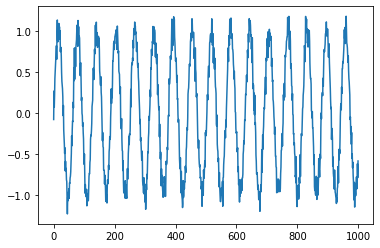

In [33]:
plt.plot(series);

Construímos o nosso conjunto de dados.

Vejamos se podemos usar T valores anteriores para prever o próximo valor:

In [34]:
T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


Setamos o dispositivo de processamento disponível:

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Definimos a RNN:

In [36]:
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        # note: batch_first=True
        # applies the convention that our data will be of shape:
        # (num_samples, sequence_length, num_features)
        # rather than:
        # (sequence_length, num_samples, num_features)
        self.rnn = nn.RNN(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            nonlinearity='relu',
            batch_first=True)
        self.fc = nn.Linear(self.M, self.K)

    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer
        # we don't need those now
        out, _ = self.rnn(X, h0)

        # we only want h(T) at the final time step
        # N x M -> N x K
        out = self.fc(out[:, -1, :])
        return out

Instanciamos o modelo:

In [37]:
model = SimpleRNN(n_inputs=1, n_hidden=15, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

Definimos a função Loss e o Otimizador:

In [38]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Dividimos os dados em treinamento e teste:

In [39]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

Movemos os dados para o dispositivo de processamento:

In [40]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

Encapsulamos o procedimento de treinamento em uma função:

In [41]:
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=1000):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
            
        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Save losses
        train_losses[it] = loss.item()

        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
            
        if (it + 1) % 5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

Treinamos o modelo:

In [42]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epoch 5/1000, Train Loss: 0.6224, Test Loss: 0.6063
Epoch 10/1000, Train Loss: 0.5720, Test Loss: 0.5590
Epoch 15/1000, Train Loss: 0.5282, Test Loss: 0.5175
Epoch 20/1000, Train Loss: 0.4900, Test Loss: 0.4814
Epoch 25/1000, Train Loss: 0.4565, Test Loss: 0.4495
Epoch 30/1000, Train Loss: 0.4258, Test Loss: 0.4201
Epoch 35/1000, Train Loss: 0.3983, Test Loss: 0.3937
Epoch 40/1000, Train Loss: 0.3719, Test Loss: 0.3675
Epoch 45/1000, Train Loss: 0.3448, Test Loss: 0.3404
Epoch 50/1000, Train Loss: 0.3166, Test Loss: 0.3119
Epoch 55/1000, Train Loss: 0.2869, Test Loss: 0.2824
Epoch 60/1000, Train Loss: 0.2567, Test Loss: 0.2523
Epoch 65/1000, Train Loss: 0.2260, Test Loss: 0.2216
Epoch 70/1000, Train Loss: 0.1950, Test Loss: 0.1908
Epoch 75/1000, Train Loss: 0.1648, Test Loss: 0.1609
Epoch 80/1000, Train Loss: 0.1367, Test Loss: 0.1330
Epoch 85/1000, Train Loss: 0.1101, Test Loss: 0.1068
Epoch 90/1000, Train Loss: 0.0893, Test Loss: 0.0874
Epoch 95/1000, Train Loss: 0.0767, Test Loss: 0

Plotamos a loss de treinamento e teste por iteração:

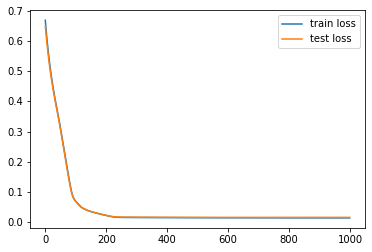

In [43]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend();

Executamos a previsão de valores futuros:

In [44]:
validation_target = Y[-N//2:]
validation_predictions = []

last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p[0,0].item())

    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

Plotamos as previsões:

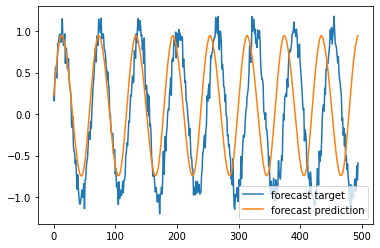

In [45]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend();